# Load in all the `.nc` files and merge to one ds

In [1]:
import xarray as xr
import dask 

In [2]:
#`open_mfdataset()` yielded errors when computing on vars 
#so need to load them in indvidiually and then merge to a single ds
#var_files = ['e', 'runoff', 'sea_surface_temperature', 'surface_latent_heat_flux', 'sub_surface_runoff', 
#             'surface_net_solar_radiation', 'surface_net_thermal_radiation', 'surface_runoff',
#             'surface_sensible_heat_flux', 'surface_solar_radiation_downwards', 'surface_thermal_radiation_downwards']

var_files = ['runoff', 'surface_runoff', 'sea_surface_temperature', 'surface_latent_heat_flux', 
            'surface_net_solar_radiation', 'surface_net_thermal_radiation', 'surface_sensible_heat_flux', 
            'e',]

#'surface_latent_heat_flux',
#to ignore warning about large chunking
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds = xr.merge([xr.open_dataset(f'2022_winter_{file}.nc', chunks={'time':15}) for file in var_files])

In [3]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 2208)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2022-10-01 ... 2022-12-31T23:00:00
Data variables:
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    str        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-11 11:04:50 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [4]:
ds.sst.isel(time=0)#.plot()

<xarray.DataArray 'sst' (latitude: 721, longitude: 1440)>
dask.array<getitem, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2022-10-01
Attributes:
    units:      K
    long_name:  Sea surface temperature

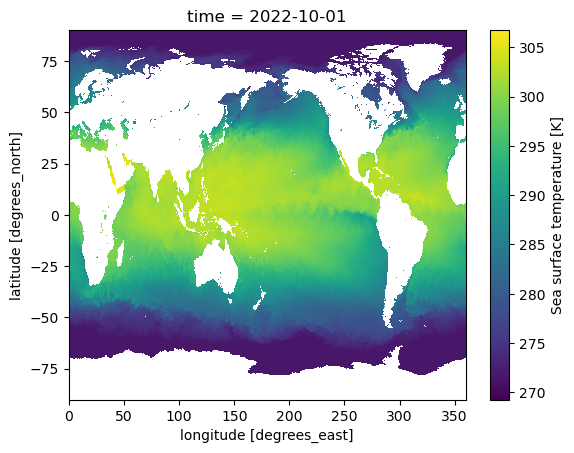

In [5]:
ds.sst.isel(time=0).plot()

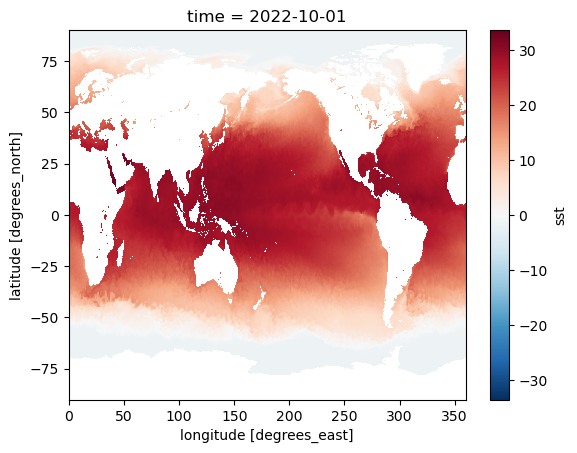

In [6]:
(ds.sst.isel(time=0) - 273.15).plot()

In [7]:
ds.coords['longitude'] = (ds.coords['longitude'] + 180) % 360 - 180
ds = ds.sortby(ds.longitude).chunk({'time':15})

In [8]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 2208)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2022-10-01 ... 2022-12-31T23:00:00
Data variables:
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    slhf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    str        (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    sshf       (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(15, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-11 11:04:50 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [9]:
(ds.sst.isel(time=0) - 273.15)

<xarray.DataArray 'sst' (latitude: 721, longitude: 1440)>
dask.array<sub, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2022-10-01

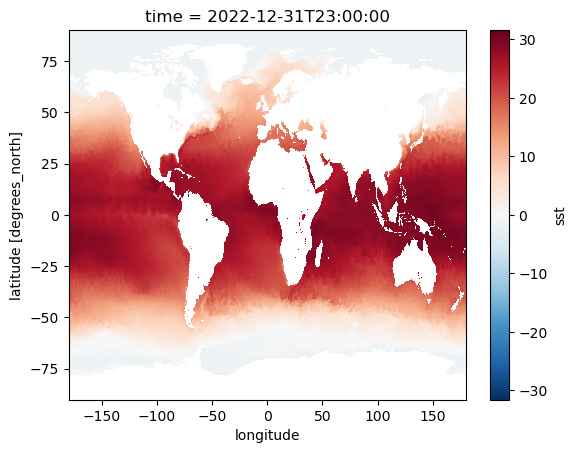

In [10]:
(ds.sst.isel(time=-1) - 273.15).plot()

In [11]:
#uploading global surf_ds
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2022_winter_surf_ds.zarr')
ds.to_zarr(gcsmap_ds, mode='w')